In [1]:
import os
import importlib.machinery
import importlib.util
loader = importlib.machinery.SourceFileLoader('baltic','/Users/evogytis/Documents/baltic/baltic.py')
spec = importlib.util.spec_from_loader(loader.name, loader)
bt = importlib.util.module_from_spec(spec)
loader.exec_module(bt)

# base_path='/Users/evogytis/Documents/manuscripts/skeeters/data/narnavirus/'
# RdRp=bt.loadNewick(os.path.join(base_path,"RAxML_bipartitionsBranchLabels.T19_narnaRdRp_rooted.newick")).collapseBranches(lambda k: k.length<=0.000001,verbose=True)
# Robin=bt.loadNewick(os.path.join(base_path,"RAxML_bipartitionsBranchLabels.T20_narnaRobin_rooted.newick")).collapseBranches(lambda k: k.length<=0.000001,verbose=True)

base_path='/Users/evogytis/Downloads/'
RdRp=bt.loadNewick(os.path.join(base_path,"Batman.midpoint.newick")).collapseBranches(lambda k: k.length==0,verbose=True)
Robin=bt.loadNewick(os.path.join(base_path,"Robin.midpoint.newick")).collapseBranches(lambda k: k.length==0,verbose=True)


RdRp.treeStats()
Robin.treeStats()

RdRp.tipMap={k.numName: k.numName for k in RdRp.getExternal()}
Robin.tipMap={k.numName: k.numName for k in Robin.getExternal()}

for k in RdRp.getExternal():
    k.name=k.numName
for k in Robin.getExternal():
    k.name=k.numName

trees={'RdRp':RdRp, 
       'Robin':Robin}

segments=['RdRp','Robin']

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

import numpy as np

typeface='Helvetica Neue'
# mpl.rcParams['font.weight']=400
mpl.rcParams['mathtext.fontset']='custom'
mpl.rcParams['font.sans-serif']=typeface
mpl.rcParams['mathtext.default']='sf'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22


1 nodes set for collapsing: [1622]
Continuing collapse cycle, 1 nodes left
Removing node 1622, attaching children [1623, 1662] to node 1582
Fixing branch length for node 1623
Fixing branch length for node 1662
Removing references to node 1622
9 nodes set for collapsing: [24, 188, 1295, 1534, 1535, 1575, 1769, 1878, 1972]
Continuing collapse cycle, 9 nodes left
Removing node 1972, attaching children [1973, 2019] to node 1925
Fixing branch length for node 1973
Fixing branch length for node 2019
Removing references to node 1972
Removing node 1769, attaching children [1770, 1878] to node 1722
Fixing branch length for node 1770
Fixing branch length for node 1878
Removing references to node 1769
Removing node 1878, attaching children [1879, 1925] to node 1722
Fixing branch length for node 1879
Fixing branch length for node 1925
Removing references to node 1878
Removing node 1295, attaching children [1318, 1296] to node 1027
Fixing branch length for node 1296
Fixing branch length for node 131

In [2]:
tip_positions={x:{} for x in segments} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y) ## remember (X, Y) position of tip

cmap=mpl.cm.Spectral

tip_positions={x:{} for x in trees} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y) ## remember (X, Y) position of tip

cmap=mpl.cm.Spectral

for X in range(10): ## 10 untangling iterations
    print('iteration %d'%(X+1))
    for t,tr in enumerate(segments): ## iterate over each tree
        print(tr)
        ptr=segments[t-1] ## previous tree
        ntr=segments[t] ## next tree
        seg=trees[ptr] ## fetch appropriate tree
        nex_seg=trees[ntr]
        for k in sorted(nex_seg.Objects,key=lambda q:q.height): ## iterate over branches from most recent to oldest
            if k.branchType=='node': ## can only sort nodes
                leaves=[[seg.tipMap[tip] for tip in w.leaves if tip in seg.tipMap] if w.branchType=='node' else [w.name] for w in k.children] ## descendent tips in current order
                
#                 leaves=[[seg.tipMap[tip] for tip in w.leaves] if w.branchType=='node' else [w.name] for w in k.children] ## descendent tips in current order
                
                for c in range(len(leaves)):
#                     leaves[c]=sorted(leaves[c],key=lambda x:tip_positions[ntr][x][1]) ## sort leaves according to their positions in the next tree
                    leaves[c]=sorted(leaves[c],key=lambda x:tip_positions[ntr][x][1] if x in tip_positions[ntr] else 0.0) ## sort leaves according to their positions in the next tree
                
                ys=[sorted([tip_positions[ntr][w][1] for w in cl if w in tip_positions[ntr]]) for cl in leaves] ## extract y positions of descendents
                merge_ys=sum(ys,[]) ## flatten list of tip y coordinates
                m,M=int(min(merge_ys)+0.5),int(max(merge_ys)+0.5)
                ypos=range(m,M+1) ## get y positions of tips in current order
                order={i:x for i,x in enumerate(leaves)} ## dict of tip order: tip name
                
                new_order=sorted(order.keys(),key=lambda x:-np.mean([(tip_positions[ptr][order[x][w]][1]-ypos[w]) for w in range(min([len(order[x]),len(ypos)])) if order[x][w] in tip_positions[ptr]])) ## get new order by sorting existing order based on y position differences
                
#                 new_order=sorted(order.keys(),key=lambda x:-np.mean([(tip_positions[ptr][order[x][w]][1]-ypos[w]) for w in range(len(order[x]))])) ## get new order by sorting existing order based on y position differences
                
                if new_order!=range(len(leaves)): ## if new order is not current order
                    k.children=[k.children[i] for i in new_order] ## assign new order of child branches
                    nex_seg.drawTree() ## update y positions

                    for w in nex_seg.Objects: ## iterate over objects in next tree
                        if w.branchType=='leaf':
                            tip_positions[ntr][w.name]=(w.height,w.y) ## remember new positions
                
        if t==0: ## if first tree
            trees[segments[t]].drawTree() ## update positions
            lvs=sorted([w for w in trees[segments[t]].Objects if w.branchType=='leaf'],key=lambda x:x.y) ## get leaves in y position order
            
            norm=mpl.colors.Normalize(0,len(lvs))
            pos_colours={w.name:cmap(norm(w.y)) for w in lvs} ## assign colour

iteration 1
RdRp
Robin
iteration 2
RdRp
Robin
iteration 3
RdRp
Robin
iteration 4
RdRp
Robin
iteration 5
RdRp
Robin
iteration 6
RdRp
Robin
iteration 7
RdRp
Robin
iteration 8
RdRp
Robin
iteration 9
RdRp
Robin
iteration 10
RdRp
Robin


0.18181322 0.211881465 0.169931755
0.23181322 0.211881465 0.169931755
0.28181322 0.211881465 0.169931755
0.33181321999999996 0.211881465 0.169931755
0.38181321999999995 0.211881465 0.169931755


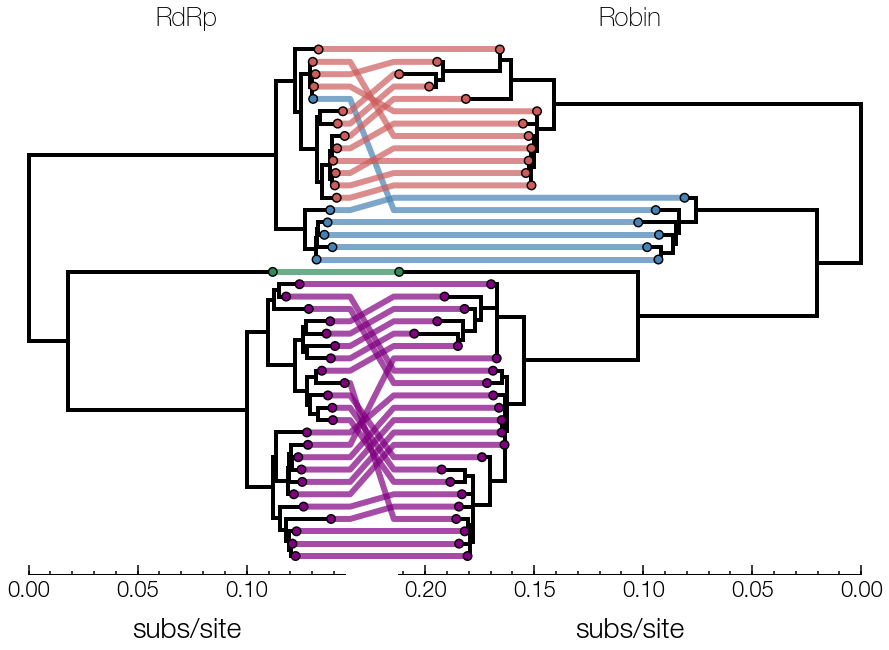

In [3]:
fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = gridspec.GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

# traitName='HA'
tree1=RdRp
tree2=Robin

# cmap=mpl.cm.Spectral
cmap=mpl.cm.viridis

# for k in tree1.getInternal():
#     if k.length>0.012:
#         print(k.index,k.length,len(k.leaves))

tip_colours={}
colour_cycle=['steelblue','seagreen','indianred','purple','seagreen']
x=0
for k in sorted(tree2.getInternal()+tree2.getExternal(),key=lambda w: w.height):
    if k.length>0.05:
        c=colour_cycle[x%len(colour_cycle)]
        if k.branchType=='node':
            for w in k.leaves:
                tip_colours[w]=c
        else:
            tip_colours[k.name]=c
        x+=1
#         print('2',k.index,k.length)
        
x_attr=lambda k: k.height ## branch x position is determined by height
y_attr=lambda k: k.y
b_func=lambda k: 4 ## branch width function
s_func=lambda k: 50 ## size of circle at tips
su_func=lambda k: 100 ## size of circle that sits underneath and acts as an outline
c_func=lambda k: 'k'
# ct_func=lambda k: cmap(k.y/float(tree2.ySpan)) ## call colour map with fraction that represents the y position of a tip (returns colour)
cu_func=lambda k: 'k' ## colour of circle sitting underneath the tip one is always black
z_func=lambda k: 100
zu_func=lambda k: 99
tree1.plotTree(ax,x_attr=x_attr,y_attr=y_attr,branchWidth=b_func,colour_function=c_func) ## plot tree
# tree1.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size_function=s_func,colour_function=ct_func,zorder_function=z_func) ## plot tip circle
# tree1.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func) ## plot tip circle outline (another circle underneath)

# skip=tree1.treeHeight*0.2 ## skip this many units between trees
skip=0.025
x_attr=lambda k: tree1.treeHeight+skip+tree2.treeHeight-k.height ## for tree2 we'll offset x coordinates by the height of the tree and invert branches
tree2.plotTree(ax,x_attr=x_attr,branchWidth=b_func,colour_function=c_func) ## plot black tree
# tree2.plotPoints(ax,x_attr=x_attr,size_function=s_func,colour_function=ct_func,zorder_function=z_func) ## plot circles at tips
# tree2.plotPoints(ax,x_attr=x_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func) ## plot circles underneath tip circles as an outline

for k in filter(lambda x: x.branchType=='leaf',tree1.Objects): ## grab leaf objects in tree1
    x=k.height ## get height
    y=k.y ## get y position
    try:
        matching_tip=tree2.getBranches(lambda x: x.branchType=='leaf' and x.name==k.name) ## fetch corresponding branch in tree2
        match_y=matching_tip.y
        xs=[x,tree1.treeHeight+0.1*skip,tree1.treeHeight+skip-0.1*skip,x_attr(matching_tip)] ## x coordinates for tangleline
        ys=[y_attr(k),y_attr(k),match_y,match_y] ## y coordinates for tangleline
        fc=tip_colours[matching_tip.name]
#         fc=cmap(match_y/float(tree2.ySpan))
        ax.scatter(x,y_attr(k),s=s_func(k),facecolor=fc,edgecolor='none',zorder=z_func(k))
        ax.scatter(x,y_attr(k),s=su_func(k),facecolor='k',edgecolor='none',zorder=zu_func(k))
        
        ax.scatter(x_attr(matching_tip),match_y,s=s_func(k),facecolor=fc,edgecolor='none',zorder=z_func(k))
        ax.scatter(x_attr(matching_tip),match_y,s=su_func(k),facecolor='k',edgecolor='none',zorder=zu_func(k))
        
        ax.plot(xs,ys,color=fc,lw=6,solid_capstyle='round',alpha=0.7) ## plot tangleline
    except:
        pass
    
cumulative_displace=0
for cur_tree in [RdRp,Robin]:
    tr='RdRp' if cur_tree==RdRp else 'Robin'
    ax.text(cumulative_displace+cur_tree.treeHeight/2,max([T.ySpan for T in [RdRp,Robin]])+1,tr,size=26,va='bottom',ha='center')
    
    xsm=np.arange(cumulative_displace,cumulative_displace+cur_tree.treeHeight,1e-2)
    xsM=np.arange(cumulative_displace,cumulative_displace+cur_tree.treeHeight,5e-2)
    if tr=='Robin':
        xsm=np.arange(cumulative_displace+cur_tree.treeHeight,cumulative_displace,-1e-2)
        xsM=np.arange(cumulative_displace+cur_tree.treeHeight,cumulative_displace,-5e-2)
        
    ax.eventplot(xsm,linelengths=0.6,colors=['k'],lineoffsets=[-1])
    ax.eventplot(xsM,linelengths=1.6,colors=['k'],lineoffsets=[-1])
    ax.plot([cumulative_displace,cumulative_displace+cur_tree.treeHeight],[-1,-1],lw=2,color='k')
    
    
    for t in xsM:
        text=t
        if tr=='Robin':
            print(t,cur_tree.treeHeight,cumulative_displace)
            
#             text=cumulative_displace-t
            text=abs(t-cumulative_displace-cur_tree.treeHeight)
#             t-=cur_tree.treeHeight
        
        ax.text(t,-1.5,'%.2f'%(text),size=22,va='top',ha='center',weight=300,clip_on=False)
        
    ax.text(cumulative_displace+cur_tree.treeHeight/2.0,-4.5,'subs/site',
            size=28,va='top',ha='center',weight=300,clip_on=False)
    
    cumulative_displace+=cur_tree.treeHeight
    cumulative_displace+=skip
    
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(-1,max(tree1.ySpan,tree2.ySpan)+1) ## set y limits
ax.set_xlim(-0.001,tree1.treeHeight+skip+tree2.treeHeight+0.001)

plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/figS8b_narna_tanglegram.pdf',dpi=300,bbox_inches='tight')
plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/figS8b_narna_tanglegram.png',dpi=300,bbox_inches='tight')

plt.show()
